# Сборный проект - 2

### Описание проекта

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. 

Компания предоставила данные с характеристиками сотрудников компании, полученную из форм обратной связи, где указан целевой признак проводимого исследования:
+ 0 — совершенно неудовлетворён
+ 1 — полностью удовлетвоён.

В таблицах данные обозначены:
+ `id` — уникальный идентификатор сотрудника;
+ `dept` — отдел, в котором работает сотрудник;
+ `level` — уровень занимаемой должности;
+ `workload` — уровень загруженности сотрудника;
+ `employment_years` — длительность работы в компании (в годах);
+ `last_year_promo` — показывает, было ли повышение за последний год;
+ `last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год;
+ `supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель;
+ `salary` — ежемесячная зарплата сотрудника;
+ `job_satisfaction_rate` — уровень удовлетворённости сотрудника работой в компании, целевой признак.


Разобъём задачу на два этапа:
1. Построим модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика, потому что удовлетворённость работой напрямую влияет на отток сотрудников. 
2. Построим модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

План работы:

1. Построение модели, которая предсказывает уровень удовлетворённости сотрудника в компании
+ 1. Загрузка данных
+ 2. Предобработка данных
+ 3. Исследовательский анализ данных
+ 4. Подготовка данных
+ 5. Обучение моделей
+ 6. Оформление выводов

2. Построение модели, которая предсказывает увольнение сотрудника из компании
+ 1. Загрузка данных
+ 2. Предобработка данных
+ 3. Исследовательский анализ данных
+ 4. Добавление нового входного признака
+ 5. Подготовка данных
+ 6. Обучение модели
+ 7. Выводы

3. Общий вывод

# Задача 1: Предсказание уровня удовлетворённости сотрудника

Установка пакетов.

In [1]:
!pip install phik -q
!pip install --upgrade scikit-learn -q
!pip install shap -q

Исследование `job_satisfaction_rate`.

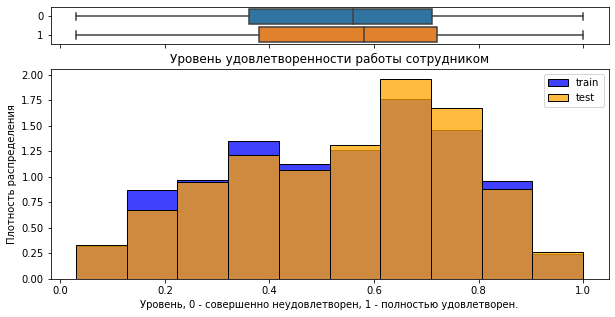

In [22]:
f_hist_box(
    train=train_job_satisfaction_rate['job_satisfaction_rate'],
    test=test_features['job_satisfaction_rate'],
    bins=10, 
    range=(0,1),
    title='Уровень удовлетворенности работы сотрудником',
    xlabel='Уровень, 0 - совершенно неудовлетворен, 1 - полностью удовлетворен.',
    ylabel='Плотность распределения'
)

Исследование строковых показателей.

In [23]:
train_job_satisfaction_rate.describe(include='object')

,dept,level,workload,last_year_promo,last_year_violations
count,3994,3996,4000,4000,4000
unique,5,3,3,2,2
top,sales,junior,medium,no,no
freq,1512,1894,2066,3880,3441


In [24]:
test_features.describe(include='object')

,dept,level,workload,last_year_promo,last_year_violations
count,1997,1999,1999,2000,2000
unique,5,3,3,2,2
top,sales,junior,medium,no,no
freq,763,974,1043,1937,1738


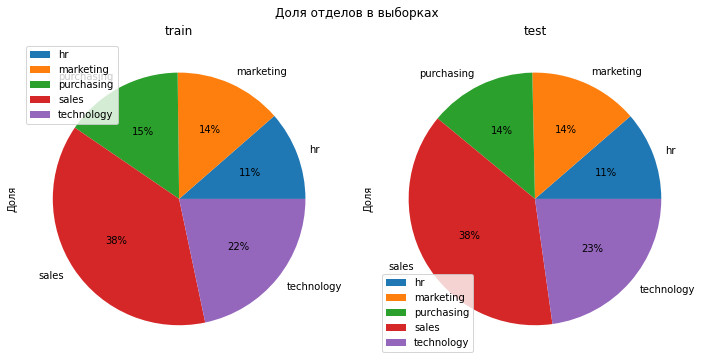

In [25]:
def f_pie_x2(train, test, col, suptitle):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
    fig.suptitle(suptitle, x=0.5, y=0.75, fontsize=12)
    
    (
    train
        .pivot_table(index=col,values='id',aggfunc='count')
        .plot.pie(y='id', autopct='%1.0f%%', figsize=(10,10), ax=ax1, 
                  label='Доля')
    )
    (
    test
        .pivot_table(index=col,values='id',aggfunc='count')
        .plot.pie(y='id', autopct='%1.0f%%', figsize=(10,10), ax=ax2, 
                  label='Доля')
    )
    ax1.set_title('train')
    ax2.set_title('test')
    plt.tight_layout()
    plt.show()

f_pie_x2(train=train_job_satisfaction_rate,
         test=test_features,
         col='dept',
         suptitle='Доля отделов в выборках'
)

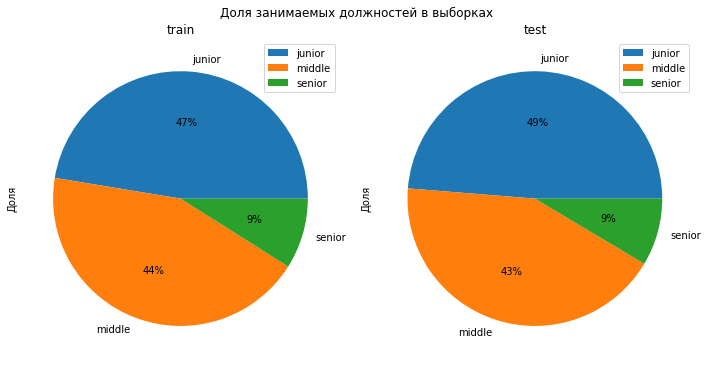

In [26]:
f_pie_x2(train=train_job_satisfaction_rate,
         test=test_features,
         col='level',
         suptitle='Доля занимаемых должностей в выборках'
)

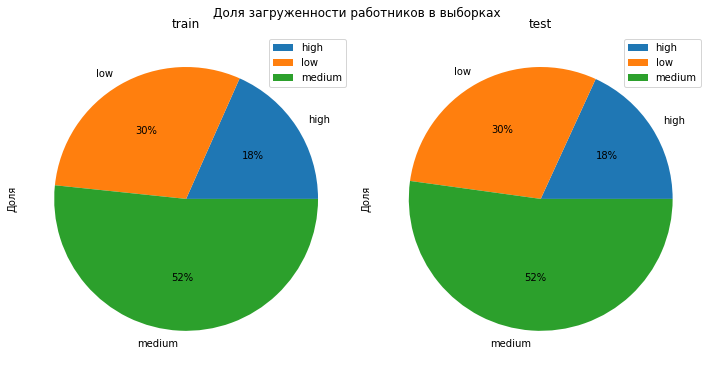

In [27]:
f_pie_x2(train=train_job_satisfaction_rate,
         test=test_features,
         col='workload',
         suptitle='Доля загруженности работников в выборках'
)

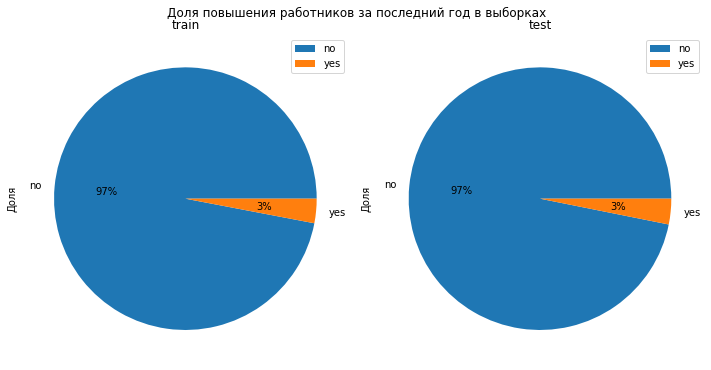

In [28]:
f_pie_x2(train=train_job_satisfaction_rate,
         test=test_features,
         col='last_year_promo',
         suptitle='Доля повышения работников за последний год в выборках'
)

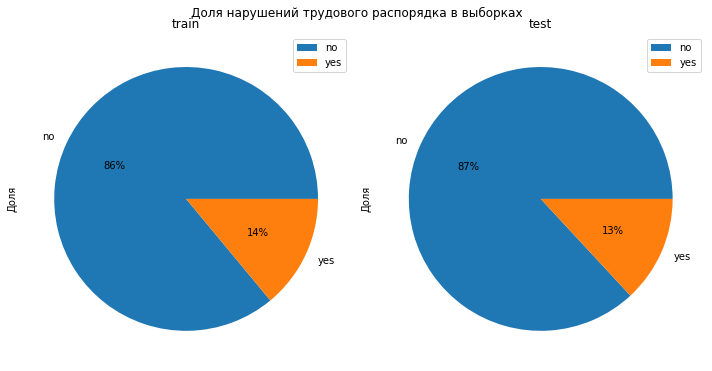

In [29]:
f_pie_x2(train=train_job_satisfaction_rate,
         test=test_features,
         col='last_year_violations',
         suptitle='Доля нарушений трудового распорядка в выборках'
)

**Вывод по анализу данных**

При проведении разведочного анализа данных (EDA) выявили:

+ employment_years 	- категориальный признак "Продолжительность работы в годах" равномерно убывает с увеличением лет, значения в обучающей и тестовой выборке примерно соответствуют друг другу.
+ supervisor_evaluation - категориальный признак "Оценка работы подчиненного Руководителем" распределение носит нормальный характер больше всего подчиненных оценено на хорошо, значения в обучающей и тестовой выборке примерно соответствуют друг другу.
+ salary - уровень заработной платы -  распределение носит нормальный характер, имеются выбромы в данных, значения в обучающей и тестовой выборке примерно соответствуют друг другу.
+ job_satisfaction_rate - уровень удовлетворенности работы сотрудником - имеет норммальное распределение, значения в обучающей и тестовой выборке примерно соответствуют друг другу.
+ dept - Доля отделов в выборках, значения в обучающей и тестовой выборке примерно соответствуют друг другу.
+ level - Доля занимаемых должностей в выборках, значения в обучающей и тестовой выборке примерно соответствуют друг другу.
+ workload - Доля загруженности работников в выборках, значения в обучающей и тестовой выборке примерно соответствуют друг другу.
+ last_year_promo - Доля повышения работников за последний год в выборках, значения в обучающей и тестовой выборке примерно соответствуют друг другу.
+ last_year_violations - Доля нарушений трудового распорядка в выборках, значения в обучающей и тестовой выборке примерно соответствуют друг другу.

Прейдем к исследованию корреляционного анализа


Назначим индексом столбец `id`.

In [30]:
train_job_satisfaction_rate = train_job_satisfaction_rate.sort_values(by=['id']).set_index('id')
test_features = test_features.sort_values(by=['id']).set_index('id')

Проведем корреляционный анализ данных для исключения мультиколлениарности.

Построим матрицу корреляции phi(k) тестовой выборки.

In [31]:
interval_cols = ['salary',
                 'job_satisfaction_rate'
                ]

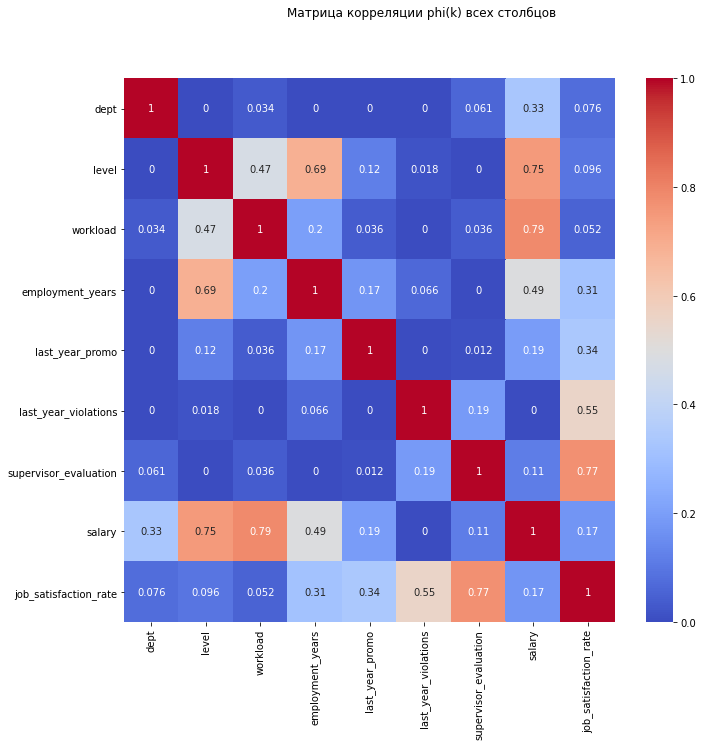

In [32]:
fig, ax = plt.subplots(figsize=(11, 10))
plt.suptitle('Матрица корреляции phi(k) всех столбцов')
sns.heatmap(test_features.phik_matrix(interval_cols=interval_cols), annot=True, cmap='coolwarm');

Построим матрицу корреляции phi(k) тренировочной выборки.

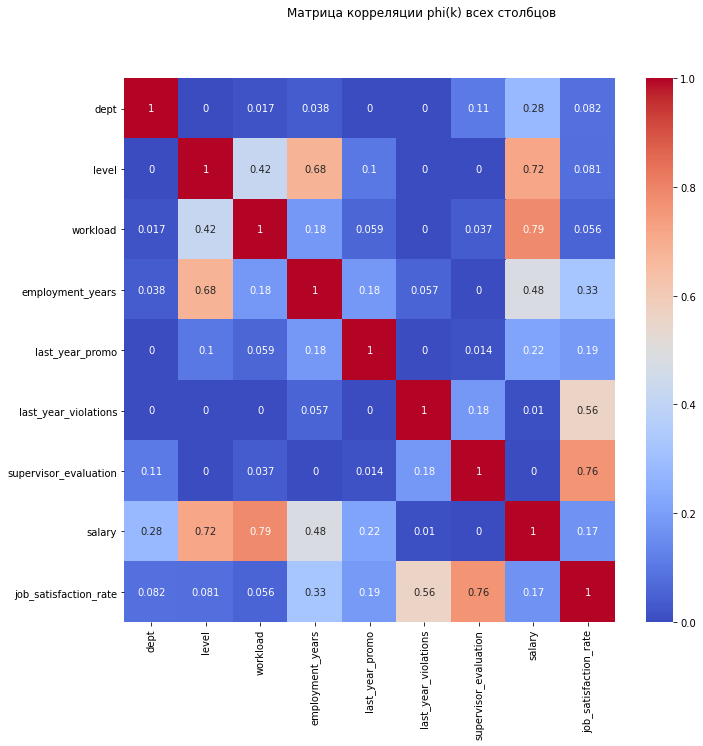

In [33]:
fig, ax = plt.subplots(figsize=(11, 10))
plt.suptitle('Матрица корреляции phi(k) всех столбцов')
sns.heatmap(train_job_satisfaction_rate.phik_matrix(interval_cols=interval_cols), annot=True, cmap='coolwarm');

#### Вывод по исследовательскому анализу данных
+ Данные `id`, переведены в индекс, отсортированы по возрастающему.
+ В данных обнаружены выбросы.
+ Между входными параметрами отсутствует связь выше 0,9 следовательно при обучении модели учитывать мультиколлинеарность не надо. 
+ На тренировочной и тестовой выборках, значения корреляции немного разнятся, но общая оценка соответствуют друг другу.
+ В колонках `dept`, `level`, `workload` необходимо заменить пропуски.
+ Три признака: `dept`, `last_year_promo`, `last_year_violations` — нужно кодировать с помощью OneHotEncoder.
+ Два признака: `level`, `workload` — нужно кодировать с помощью OrdinalEncoder.
+ Три признака: `employment_years`, `supervisor_evaluation`, `salary` - достаточно масштабировать.

Проведем  заполнение пропусков, кодирование и масштабирование в пайплайне.

## 4. Подготовка данных

In [34]:
print(train_job_satisfaction_rate.info(), '\n-----------------------------------')
train_job_satisfaction_rate = train_job_satisfaction_rate.drop_duplicates()
train_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 100954 to 999521
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   3994 non-null   object 
 1   level                  3996 non-null   object 
 2   workload               4000 non-null   object 
 3   employment_years       4000 non-null   int64  
 4   last_year_promo        4000 non-null   object 
 5   last_year_violations   4000 non-null   object 
 6   supervisor_evaluation  4000 non-null   int64  
 7   salary                 4000 non-null   int64  
 8   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 312.5+ KB
None 
-----------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3755 entries, 100954 to 999521
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  

Количество строк в обучающих данных сократилось с 4000 до 3755 после удаления полных дубликатов, что должно положительно сказаться на процессе обучения моделей.

In [35]:
RANDOM_STATE = 42

X_train_1 = train_job_satisfaction_rate.drop('job_satisfaction_rate', axis=1)
y_train_1 = train_job_satisfaction_rate['job_satisfaction_rate'] 
X_test_1 = test_features.drop('job_satisfaction_rate', axis=1)
y_test_1 = test_features['job_satisfaction_rate']

ohe_columns = ['dept', 'last_year_promo', 'last_year_violations'] 
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']

In [36]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

In [37]:
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'], 
                    ['low', 'medium', 'high']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),

    ]
)

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', RobustScaler(), num_columns)
    ], 
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

In [38]:
X_train_1_transformed = pd.DataFrame(data_preprocessor.fit_transform(X_train_1), columns=data_preprocessor.get_feature_names_out())
X_test_1_transformed = pd.DataFrame(data_preprocessor.transform(X_test_1), columns=data_preprocessor.get_feature_names_out())

X_train_1_transformed.info(), X_test_1_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ohe__dept_marketing            3755 non-null   float64
 1   ohe__dept_purchasing           3755 non-null   float64
 2   ohe__dept_sales                3755 non-null   float64
 3   ohe__dept_technology           3755 non-null   float64
 4   ohe__last_year_promo_yes       3755 non-null   float64
 5   ohe__last_year_violations_yes  3755 non-null   float64
 6   ord__level                     3755 non-null   float64
 7   ord__workload                  3755 non-null   float64
 8   num__employment_years          3755 non-null   float64
 9   num__supervisor_evaluation     3755 non-null   float64
 10  num__salary                    3755 non-null   float64
dtypes: float64(11)
memory usage: 322.8 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1

(None, None)

#### Вывод по подготовке данных
+ Данные для обучения модели в пайплайне подготовлены.
+ Заполнены пропуски.
+ Проведено кодирование в соответствии с признаками (использовано два кодировщика `ohe - OneHotEncoder`, `ord - OrdinalEncoder`).
+ Проведено масштабирование данных.

## 5. Обучение моделей

Подготовим  целевую функцию SMAPE.

In [39]:
def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum( np.abs(y_true - y_pred) / ((np.abs(y_true) + np.abs(y_pred))/2) ) 
   
smape_scorer = make_scorer(score_func=smape, greater_is_better=False)

In [40]:
param_grid = [

    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']   
    },

    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': [None] + [i for i in range(2, 7)],
        'models__max_features': range(2, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    }
]

In [41]:
rs = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=smape_scorer,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rs.fit(X_train_1, y_train_1)
print('Лучшая модель и её параметры:\n\n', rs.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', rs.best_score_*(-1))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                            

In [42]:
print(f'Метрика SMAPE лучшей модели на тестовой выборке: {round(smape(y_test_1, rs.predict(X_test_1)),4)}')

Метрика SMAPE лучшей модели на тестовой выборке: 14.7877


Отобразим лучшую модель и её параметры.

In [43]:
all_model_1 = pd.DataFrame(rs.cv_results_).sort_values(by=['rank_test_score'])
all_model_1[['rank_test_score',
    'param_models',
    'params'
]].head(1)

,rank_test_score,param_models,params
1,1,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 9, 'models__max_depth': None, 'models': DecisionTreeRegressor(random_state=42)}"


#### Вывод по обучению моделей

Лучшей моделью определена: `DecisionTreeRegressor(max_features=9, random_state=42)`

с параметрами: `{'preprocessor__num': MinMaxScaler(), 'models__max_features': 9, 'models__max_depth': None, 'models': DecisionTreeRegressor(max_features=9, random_state=42)}`

Качество модели удовлетворяет критерию успеха SMAPE ≤ 15 на тестовой выборке: 14.7877.

Проверим адекватность модели, сравнив её качество предсказаний с `DummyRegressor` - предсказывает констанстные значения.\
Сравнение проведем на основе целевой функции SMARE.

In [44]:
dummy_regr = DummyRegressor(strategy="median")
dummy_regr.fit(X_train_1, y_train_1)
print(f'Метрика SMAPE модели `DummyRegressor` на обучающей выборке: {round(smape(y_train_1, dummy_regr.predict(X_train_1)),4)}')
print(f'Метрика SMAPE модели `DummyRegressor` на тестовой выборке: {round(smape(y_test_1, dummy_regr.predict(X_test_1)),4)}')

Метрика SMAPE модели `DummyRegressor` на обучающей выборке: 39.9483
Метрика SMAPE модели `DummyRegressor` на тестовой выборке: 37.7728


## 6. Оформление выводов

В процессе обучения моделей и подбора параметров работа производилась для:
1. LinearRegression()
2. DecisionTreeRegressor()

В процессе работы отобрана лучшая модель: `DecisionTreeRegressor(max_features=9, random_state=42)`

с параметрами: `{'preprocessor__num': MinMaxScaler(), 'models__max_features': 9, 'models__max_depth': None, 'models': DecisionTreeRegressor(max_features=9, random_state=42)}`

В процессе работы отбор модели производился по целевой функции SMAPE. 

Качество лучшей модели удовлетворяет критерию успеха SMAPE ≤ 15 на тестовой выборке: 14.7877.

Целевой показатель превосходит значение модели `DummyRegressor`, значит выбранная модель адекватна.

Почему LinearRegression() хуже справилась с поставленной задачей:
+ потому что матрица корреляции, явно показала отсутствие явной линейной зависимости между входными и целевыми показателями максимальное значение phi(k) = 0,79.
+ потому что DecisionTreeRegressor() оперативно подстроилась между входными и целевыми параметрами во время обучения.

# Задача 2: Предсказание увольнения сотрудника из компании

## 1. Загрузка данных

In [45]:
pth1 = '/datasets/train_quit.csv'
pth2 = 'https://code.s3.yandex.net/datasets/train_quit.csv'

if os.path.exists(pth1):
    train_quit = pd.read_csv(pth1)
else:
    train_quit = pd.read_csv(pth2)
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [46]:
pth1 = '/datasets/test_features.csv'
pth2 = 'https://code.s3.yandex.net/datasets/test_features.csv'

if os.path.exists(pth1):
    test_features_2 = pd.read_csv(pth1)
else:
    test_features_2 = pd.read_csv(pth2)
test_features_2.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [47]:
pth1 = '/datasets/test_target_quit.csv'
pth2 = 'https://code.s3.yandex.net/datasets/test_target_quit.csv'

if os.path.exists(pth1):
    test_target_quit = pd.read_csv(pth1)
else:
    test_target_quit = pd.read_csv(pth2)
test_target_quit.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


Данные прочитаны. Прейдем к предобработке.

## 2. Предобработка данных

Удаление полных дубликатов при их наличии.

In [48]:
train_quit.drop_duplicates()
train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [49]:
test_features_2.drop_duplicates()
test_features_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [50]:
test_target_quit.drop_duplicates()
test_target_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


Проверка сопоставимости данных в `test_features` и `test_target_quit`.

In [51]:
test_features_2 = pd.merge(test_features_2, test_target_quit, on='id', sort=True)
print(test_features_2.info())
test_features_2.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
 9   quit                   2000 non-null   object
dtypes: int64(4), object(6)
memory usage: 171.9+ KB
None


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,100298,hr,junior,low,2,no,no,4,19200,no
1,100480,marketing,junior,low,4,no,no,4,16800,no
2,100503,purchasing,middle,high,5,no,no,4,55200,no
3,100610,sales,middle,medium,5,no,no,4,43200,no
4,100692,sales,middle,high,6,no,no,4,48000,no


Таблицы объединены, при этом количество пропусков не увеличилось, данные соответствуют друг другу.

Проверка совпадений в названиях колонок.

In [52]:
if list(train_quit)==list(test_features_2):
    print('Полное совпадение названий колонок')
else:
    print('Нет совпадения в названиях колонок')

Полное совпадение названий колонок


Проверка перекрестного совпадения значений `id` в тестовой и тренировочной выборке.

In [53]:
print('Количество перекрестных совпадений "id" в  таблицах = ', len(train_quit[train_quit['id'].isin(test_features_2['id'].unique())]))

Количество перекрестных совпадений "id" в  таблицах =  0


Попарное сравнение данных, замена `' '` на `nan`.

In [54]:
test_features_2['dept'] = test_features_2['dept'].replace(' ', np.nan)
test_features_2['workload'] = test_features_2['workload'].replace(' ', np.nan)
train_quit['level'] = train_quit['level'].replace('sinior', 'senior')
test_features_2['level'] = test_features_2['level'].replace('sinior', 'senior')
for col in train_quit.keys().drop(labels=['id']):
    print('Уникальные значения в колонке =', col)
    print(train_quit[col].unique())
    print(test_features_2[col].unique(), '\n---------------------------------------')   

Уникальные значения в колонке = dept
['sales' 'purchasing' 'marketing' 'technology' 'hr']
['hr' 'marketing' 'purchasing' 'sales' 'technology' nan] 
---------------------------------------
Уникальные значения в колонке = level
['middle' 'junior' 'senior']
['junior' 'middle' 'senior' nan] 
---------------------------------------
Уникальные значения в колонке = workload
['high' 'medium' 'low']
['low' 'high' 'medium' nan] 
---------------------------------------
Уникальные значения в колонке = employment_years
[ 2  5  1  8  4  7  3  9  6 10]
[ 2  4  5  6  3  8  1  9  7 10] 
---------------------------------------
Уникальные значения в колонке = last_year_promo
['no' 'yes']
['no' 'yes'] 
---------------------------------------
Уникальные значения в колонке = last_year_violations
['no' 'yes']
['no' 'yes'] 
---------------------------------------
Уникальные значения в колонке = supervisor_evaluation
[4 1 3 5 2]
[4 3 1 2 5] 
---------------------------------------
Уникальные значения в колонке

#### Вывод по предобработке данных
+ В колонках данные соответствуют типу.
+ Дубликаты не обнаружены.
+ Выявлены пропуски в колонках `dept`и `level`, в колонках `test_features['dept']` и `test_features['workload']` обнаружены пробелы, проведена замена пробелов `' '` на `np.nan`. 

Проведем в дальнейшем заполнение пропусков в пайплайне при обучении модели с использованием SimpleImputer.

## 3. Исследовательский анализ данных

### 3.1 Исследовательский анализ данных

Исследование числовых показателей.

In [55]:
train_quit.describe()

,id,employment_years,supervisor_evaluation,salary
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,552099.283750,3.701500,3.474750,33805.800000
std,260158.031387,2.541852,1.004049,15152.415163
min,100222.000000,1.000000,1.000000,12000.000000
25%,327785.750000,2.000000,3.000000,22800.000000
50%,546673.000000,3.000000,4.000000,30000.000000
75%,781497.750000,6.000000,4.000000,43200.000000
max,999915.000000,10.000000,5.000000,96000.000000


In [56]:
test_features_2.describe()

,id,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,552765.213500,3.666500,3.526500,34066.800000
std,253851.326129,2.537222,0.996892,15398.436729
min,100298.000000,1.000000,1.000000,12000.000000
25%,339052.000000,1.000000,3.000000,22800.000000
50%,550793.000000,3.000000,4.000000,30000.000000
75%,765763.750000,6.000000,4.000000,43200.000000
max,999029.000000,10.000000,5.000000,96000.000000


Исследование `employment_years`.

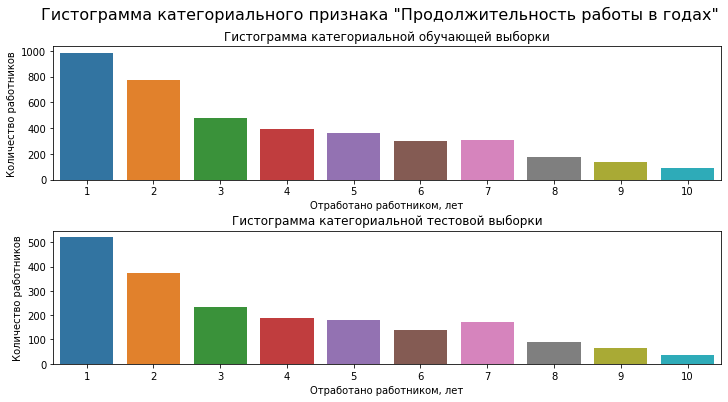

In [57]:
f_countplot(
    train=train_quit['employment_years'],
    test=test_features_2['employment_years'],
    suptitle = 'Гистограмма категориального признака "Продолжительность работы в годах"',
    xlabel='Отработано работником, лет',
    ylabel='Количество работников'
)

Исследование `supervisor_evaluation`.

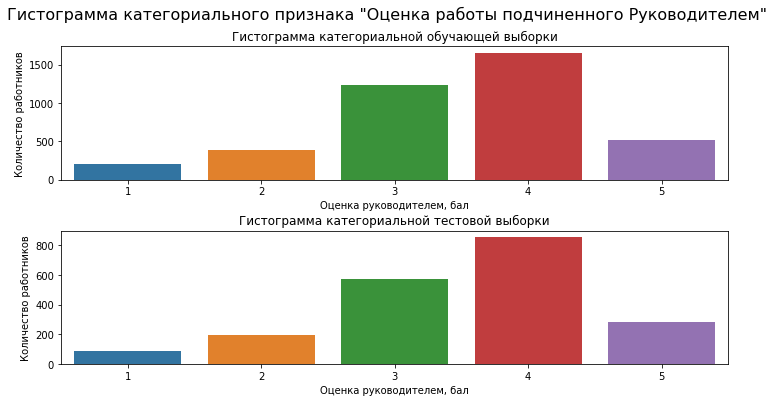

In [58]:
f_countplot(
    train=train_quit['supervisor_evaluation'],
    test=test_features_2['supervisor_evaluation'],
    suptitle = 'Гистограмма категориального признака "Оценка работы подчиненного Руководителем"',
    xlabel='Оценка руководителем, бал',
    ylabel='Количество работников'
)

Исследование `salary`.

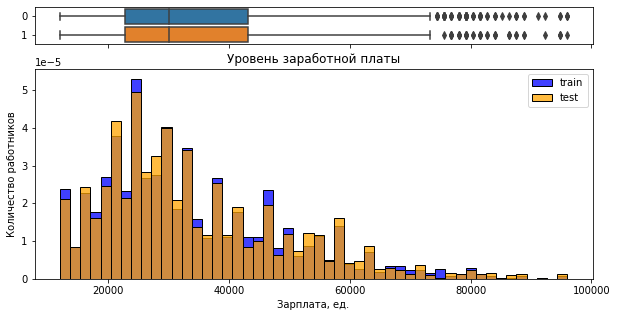

In [59]:
f_hist_box(
    train=train_quit['salary'],
    test=test_features_2['salary'],
    bins=50,
    range=(train_quit['salary'].min(),train_quit['salary'].max()),
    title='Уровень заработной платы',
    xlabel='Зарплата, ед.',
    ylabel='Количество работников'
)

Исследование строковых показателей.

In [60]:
train_quit.describe(include='object')

,dept,level,workload,last_year_promo,last_year_violations,quit
count,4000,4000,4000,4000,4000,4000
unique,5,3,3,2,2,2
top,sales,junior,medium,no,no,no
freq,1438,1949,2118,3887,3455,2872


In [61]:
test_features_2.describe(include='object')

,dept,level,workload,last_year_promo,last_year_violations,quit
count,1997,1999,1999,2000,2000,2000
unique,5,3,3,2,2,2
top,sales,junior,medium,no,no,no
freq,763,974,1043,1937,1738,1436


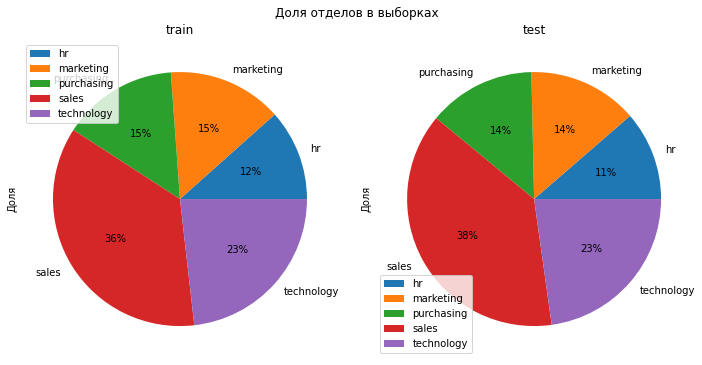

In [62]:
f_pie_x2(train=train_quit,
         test=test_features_2,
         col='dept',
         suptitle='Доля отделов в выборках'
)

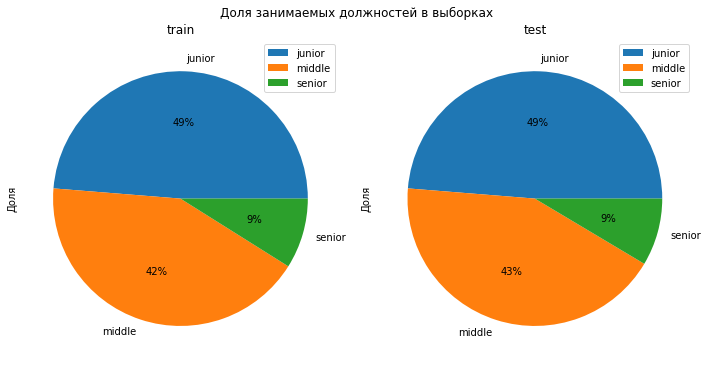

In [63]:
f_pie_x2(train=train_quit,
         test=test_features_2,
         col='level',
         suptitle='Доля занимаемых должностей в выборках'
)

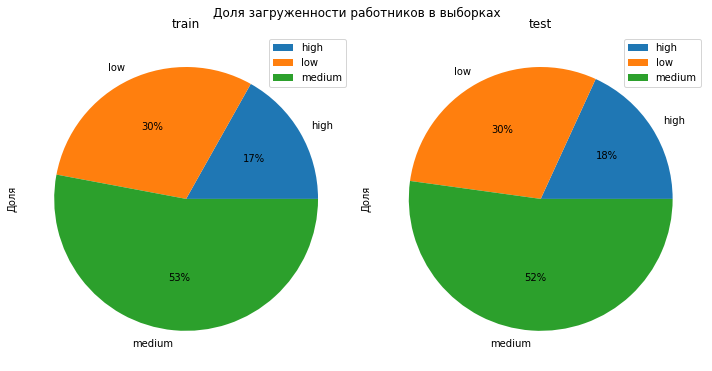

In [64]:
f_pie_x2(train=train_quit,
         test=test_features_2,
         col='workload',
         suptitle='Доля загруженности работников в выборках'
)

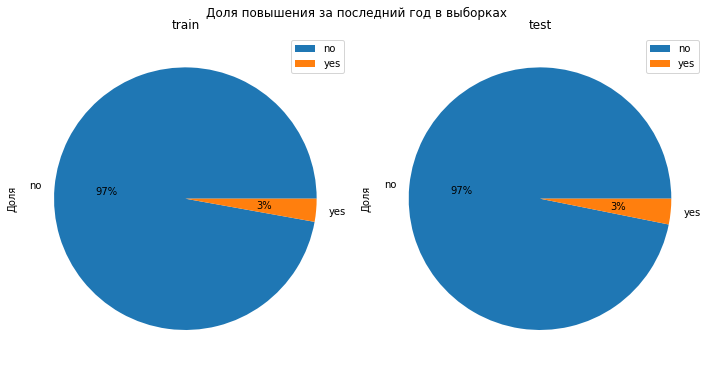

In [65]:
f_pie_x2(train=train_quit,
         test=test_features_2,
         col='last_year_promo',
         suptitle='Доля повышения за последний год в выборках'
)

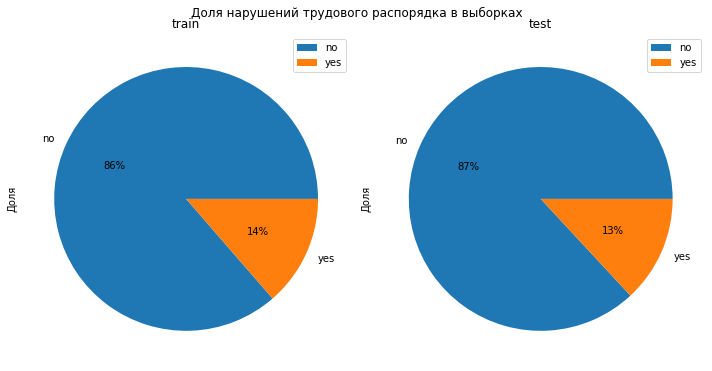

In [66]:
f_pie_x2(train=train_quit,
         test=test_features_2,
         col='last_year_violations',
         suptitle='Доля нарушений трудового распорядка в выборках'
)

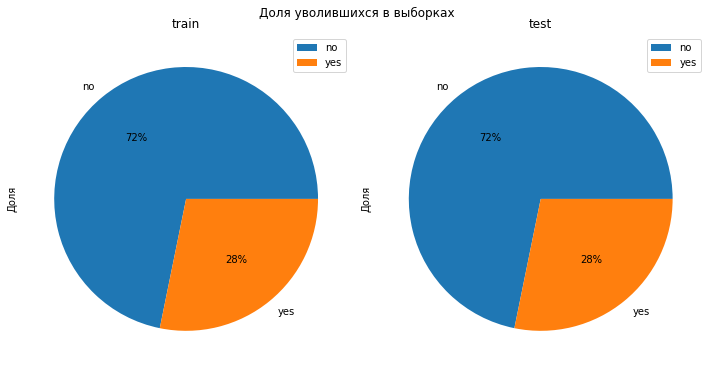

In [67]:
f_pie_x2(train=train_quit,
         test=test_features_2,
         col='quit',
         suptitle='Доля уволившихся в выборках'
)

#### Промежуточный вывод по исследовательскому анализу данных

Проведенный исследовательский анализ данных указывает на совпадение данных в обучающей и тестовой выборках, проведение дальнейшей работы возможно, при этом:

+ Данные `id`, переведены в индекс, отсортированы по возрастающей.
+ В данных обнаружены выбросы.
+ В колонках `dept`, `level`, `workload` необходимо заменить пропуски.
+ Три признака: `dept`, `last_year_promo`, `last_year_violations` — нужно кодировать с помощью OneHotEncoder.
+ Два признака: `level`, `workload` — нужно кодировать с помощью OrdinalEncoder.
+ Три признака: `employment_years`, `supervisor_evaluation`, `salary` - необходимо масштабировать.
+ Целевой признак перевести к числовым значениям 1 - yes - уволился, 0 - no - работает.

Проведем  заполнение пропусков, кодирование и масштабирование в пайплайне.

### 3.2 Портрет уволившегося сотрудника

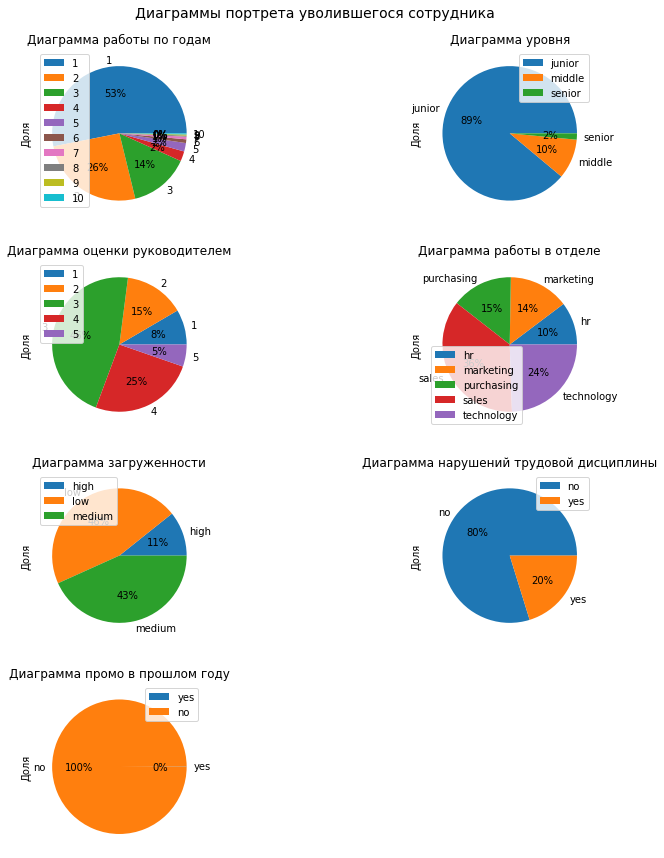

In [68]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 12))
fig.suptitle('Диаграммы портрета уволившегося сотрудника', x=0.5, y=0.99, fontsize=14)

(
train_quit.query('quit == "yes"') 
.pivot_table(index='employment_years', values='id', aggfunc='count')
.plot.pie(y='id', autopct='%1.0f%%', ax=axes[0,0], label='Доля')
)
(
train_quit.query('quit == "yes"') 
.pivot_table(index='level', values='id', aggfunc='count')
.plot.pie(y='id', autopct='%1.0f%%', ax=axes[0,1], label='Доля')
)
(
train_quit.query('quit == "yes"') 
.pivot_table(index='supervisor_evaluation', values='id', aggfunc='count')
.plot.pie(y='id', autopct='%1.0f%%', ax=axes[1,0], label='Доля')
)
(
train_quit.query('quit == "yes"') 
.pivot_table(index='dept', values='id', aggfunc='count')
.plot.pie(y='id', autopct='%1.0f%%', ax=axes[1,1], label='Доля')
)
(
train_quit.query('quit == "yes"') 
.pivot_table(index='workload', values='id', aggfunc='count')
.plot.pie(y='id', autopct='%1.0f%%', ax=axes[2,0], label='Доля')
)
(
train_quit.query('quit == "yes"') 
.pivot_table(index='last_year_violations', values='id', aggfunc='count')
.plot.pie(y='id', autopct='%1.0f%%', ax=axes[2,1], label='Доля')
)
(
train_quit.query('quit == "yes"')
.pivot_table(index='last_year_promo', values='id', aggfunc='count')
.reindex(['yes','no'], fill_value=0)
.plot.pie(y='id', autopct='%1.0f%%', ax=axes[3,0], label='Доля')
)

axes[0,0].set_title('Диаграмма работы по годам')
axes[0,1].set_title('Диаграмма уровня')
axes[1,0].set_title('Диаграмма оценки руководителем')
axes[1,1].set_title('Диаграмма работы в отделе')
axes[2,0].set_title('Диаграмма загруженности')
axes[2,1].set_title('Диаграмма нарушений трудовой дисциплины')
axes[3,0].set_title('Диаграмма промо в прошлом году')

fig.delaxes(axes[3,1])

plt.tight_layout()
plt.show()


In [69]:
train_quit.pivot_table(index = 'quit', values = 'salary', aggfunc = 'median')

,salary
quit,
no,34800
yes,22800


#### Промежуточный вывод по портрету уволившегося сотрудника
+ Начинающий сотрудник (отработал всего год) с вероятностью 53%.
+ Навыки работы - junior с вероятностью 89%.
+ Оценен руководителем на 3 по 5-ти бальной шкале с вероятностью 46%.
+ Является сотрудником отдела Sales с вероятностью 36%, отдела Technology - 24%.
+ Загрузка сотрудника Low с вероятностью 46% и Medium - 43%.
+ В течении года нарушал трудовую дисциплину с вероятностью 20%
+ Медианная заработная плата составляет 22800, в то время как продолживших работать 34800.

### 3.3 Влияние уровеня удовлетворённости сотрудника работой на его увольнение

Проведем объединение целевых признаков по `id`.

In [70]:
p_df = pd.merge(test_target_quit, test_target_job_satisfaction_rate, on='id', sort=True).sort_values(by='id')

Построим `гистограмму` и `boxplot` целевых признаков.

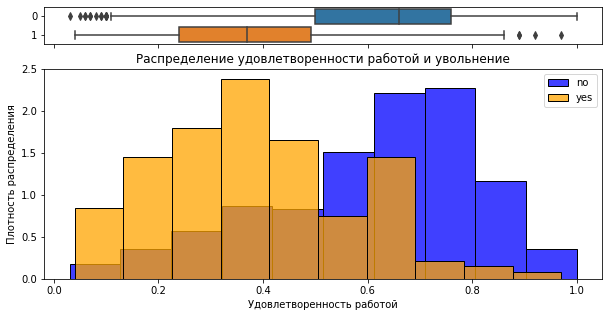

In [71]:
col = 'job_satisfaction_rate'
f, (ax_box, ax_hist) = plt.subplots(
    2, sharex=True, figsize=(10,5), 
    gridspec_kw={"height_ratios": (.15, .85)}
)

sns.boxplot(
    data=[p_df[p_df['quit']=='no'][col], p_df[p_df['quit']=='yes'][col]], 
    orient="h", ax=ax_box
)

sns.histplot(
    p_df[p_df['quit']=='no'][col], 
    bins=10, stat="density", common_norm=False, 
    label="no", color="blue", ax=ax_hist
)
sns.histplot(
    p_df[p_df['quit']=='yes'][col], 
    bins=10, stat="density", common_norm=False, 
    label="yes", color="orange", ax=ax_hist
)

ax_hist.legend(loc='upper right')
ax_hist.set_title('Распределение удовлетворенности работой и увольнение')
ax_hist.set_xlabel('Удовлетворенность работой')
ax_hist.set_ylabel('Плотность распределения')

plt.show()


Построим Плотность распределения (KDE) коэффициента удовлетворенности работой.

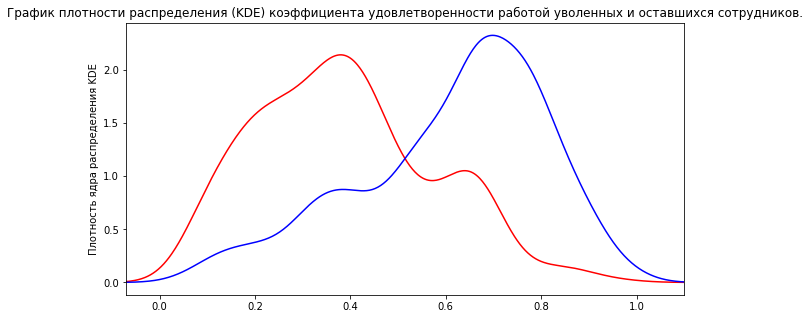

In [72]:
plt.figure(figsize=(10,5))
plt.title('График плотности распределения (KDE) коэффициента удовлетворенности работой уволенных и оставшихся сотрудников.')
plt.xlim (p_df['job_satisfaction_rate'].min()-0.1, p_df['job_satisfaction_rate'].max()+0.1)
ax = p_df[p_df['quit']=='yes']['job_satisfaction_rate'].plot.kde(color='red')
ax = p_df[p_df['quit']=='no']['job_satisfaction_rate'].plot.kde(color='blue')
ax.set_ylabel('Плотность ядра распределения KDE')
plt.show()

#### Промежуточный вывод по влиянию уровеня удовлетворённости сотрудника работой на его увольнение
Построенные гистограммы с боксплотами плотности распределения удовлетворенности работой указывают на связь с увольнением сотрудников. В общем случае можно сказать, что увольняются работники, которые не удовлетворены работой.

Выдвенем гипотезы:\
H0: Средние значения совокупной выборки равны, а значит зависимости между увольнением и удовлетворенностью работой нет.\
H1: Средние значения совокупной выборки не равны, а значит есть зависимости между увольнением и удовлетворенностью работой.

In [73]:
group1 = p_df[p_df['quit']=='yes']
group2 = p_df[p_df['quit']=='no']

print(ttest_ind(group1['job_satisfaction_rate'], group2['job_satisfaction_rate']))

print(ttest_ind(group1['job_satisfaction_rate'], group2['job_satisfaction_rate'], equal_var= False ))

Ttest_indResult(statistic=-23.074784903634534, pvalue=1.231122066517193e-104)
Ttest_indResult(statistic=-23.795097591114747, pvalue=2.7708628031539788e-101)


Поскольку p-значение меньше 0,05, мы отклоняем нулевую гипотезу t-критерия и делаем вывод, что средние значения генеральной совокупности не равны, значит есть зависимость между увольнением и неудовлетворенностью работой.

## 4. Добавление нового входного признака

Добавим `job_satisfaction_rate`, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи.

In [74]:
train_quit['job_satisfaction_rate'] = rs.predict(train_quit)
test_features_2['job_satisfaction_rate'] = rs.predict(test_features_2)
train_quit.info(), test_features_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   4000 non-null   object 
 2   level                  4000 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   quit                   4000 non-null   object 
 10  job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(6)
memory usage: 343.9+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dt

(None, None)

Дополнение таблиц новыми данными прошло успешно, пропуски в новых данных отсутствуют, проверим корреляционную взаимосвязь данных.

Назначим индексом столбец `id`.

In [75]:
train_quit = train_quit.sort_values(by=['id']).set_index('id')
test_features_2 = test_features_2.sort_values(by=['id']).set_index('id')

Удалим полные дубликаты в тренировочной выборке после назначения `id` индексом, это должно положительно повлиять на процес обучения моделей.

In [76]:
print(train_quit.info(), '\n---------------------------------------')
train_quit = train_quit.drop_duplicates()
train_quit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 100222 to 999915
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   4000 non-null   object 
 1   level                  4000 non-null   object 
 2   workload               4000 non-null   object 
 3   employment_years       4000 non-null   int64  
 4   last_year_promo        4000 non-null   object 
 5   last_year_violations   4000 non-null   object 
 6   supervisor_evaluation  4000 non-null   int64  
 7   salary                 4000 non-null   int64  
 8   quit                   4000 non-null   object 
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(3), object(6)
memory usage: 343.8+ KB
None 
---------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2587 entries, 100222 to 999915
Data columns (total 10 columns):
 #   Column                 Non-Null C

После удаления полных дубликатов обучающая выборка сократилась с 4000 строк до 2587.

Построим матрицу корреляции phi(k) тренировочной выборки.

In [77]:
interval_cols = ['salary',
                 'job_satisfaction_rate'
                ]

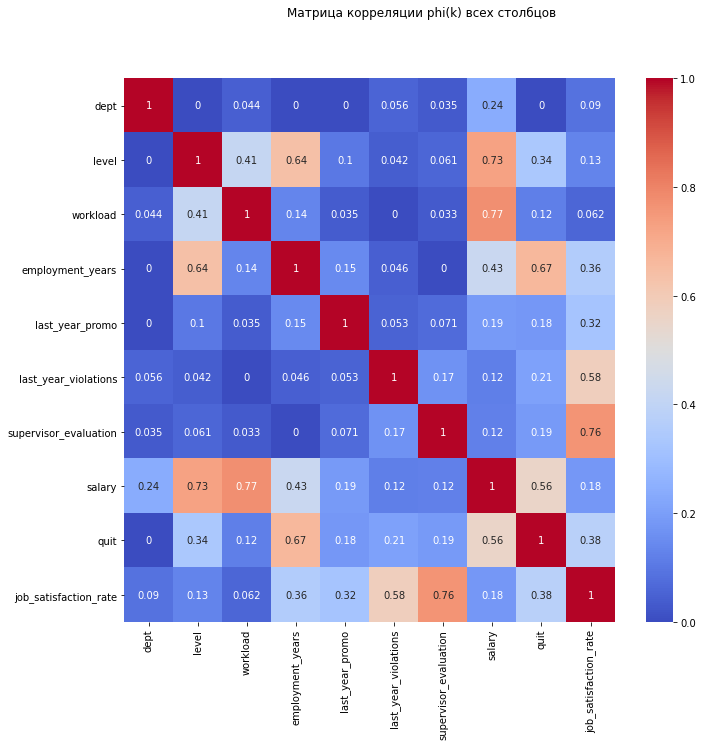

In [78]:
fig, ax = plt.subplots(figsize=(11, 10))
plt.suptitle('Матрица корреляции phi(k) всех столбцов')
sns.heatmap(train_quit.phik_matrix(interval_cols=interval_cols), annot=True, cmap='coolwarm');

Построим матрицу корреляции phi(k) тестовой выборки.

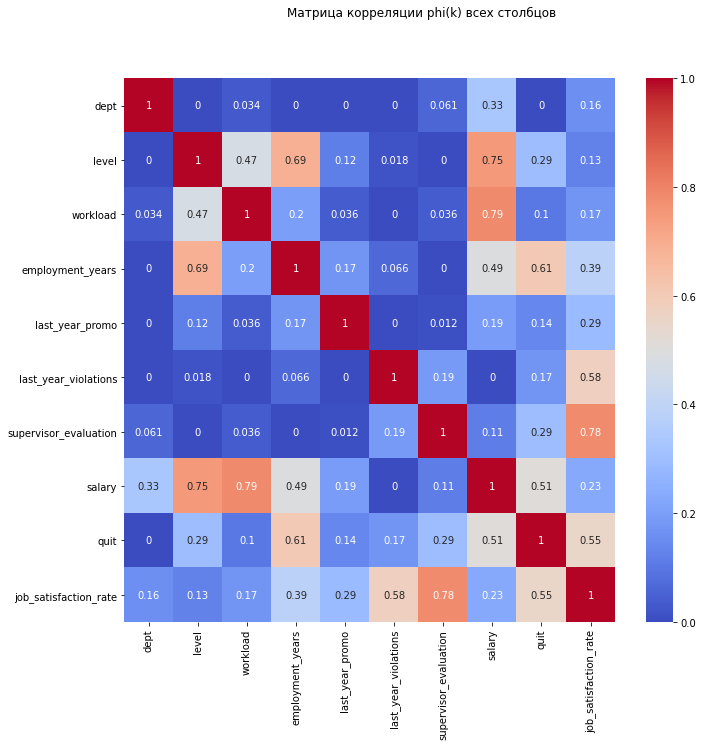

In [79]:
fig, ax = plt.subplots(figsize=(11, 10))
plt.suptitle('Матрица корреляции phi(k) всех столбцов')
sns.heatmap(test_features_2.phik_matrix(interval_cols=interval_cols), annot=True, cmap='coolwarm');

#### Вывод по добавлению нового входного признака
+ Данные `id`, переведены в индекс, отсортированы по возрастающей.
+ В данных обнаружены выбросы.
+ Между входными параметрами отсутствует связь выше 0,9 следовательно при обучении модели учитывать мультиколлинеарность не надо. 
+ На тренировочной и тестовой выборках, значения корреляции немного разнятся, но общая оценка соответствуют друг другу.
+ К исходным данным добавлен уровень удовлетворенности работой `job_satisfaction_rate` полученный на основе лучшей модели.
+ В колонках `dept`, `level`, `workload` необходимо заменить пропуски.
+ Три признака: `dept`, `last_year_promo`, `last_year_violations` — нужно кодировать с помощью OneHotEncoder.
+ Два признака: `level`, `workload` — нужно кодировать с помощью OrdinalEncoder.
+ Четыре признака: `employment_years`, `supervisor_evaluation`, `salary`, `job_satisfaction_rate`- достаточно масштабировать.

Проведем  заполнение пропусков, кодирование и масштабирование в пайплайне.

## 5. Подготовка данных

В подготовке данных к обучению модели добавляется признак `job_satisfaction_rate`, он содержит числовые значения и подлежит масштабированию, `ohe_columns`, `ord_columns` без изменений.

In [80]:
le = LabelEncoder()
le.fit_transform(train_quit['quit'].unique())
print ('Значениям', le.classes_, 'назначено соответственно', le.transform(le.classes_))
train_quit['quit'] = le.transform(train_quit['quit'])
test_features_2['quit'] = le.transform(test_features_2['quit'])

Значениям ['no' 'yes'] назначено соответственно [0 1]


In [81]:
X_train_2 = train_quit.drop('quit', axis=1)
y_train_2 = train_quit['quit'] 
X_test_2 = test_features_2.drop('quit', axis=1)
y_test_2 = test_features_2['quit']

num_columns = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']

Переопределение `data_preprocessor`.

In [82]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', RobustScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [83]:
X_train_2_transformed = pd.DataFrame(data_preprocessor.fit_transform(X_train_2), columns=data_preprocessor.get_feature_names_out())
X_test_2_transformed = pd.DataFrame(data_preprocessor.transform(X_test_2), columns=data_preprocessor.get_feature_names_out())

X_train_2_transformed.info(), X_test_2_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2587 entries, 0 to 2586
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ohe__dept_marketing            2587 non-null   float64
 1   ohe__dept_purchasing           2587 non-null   float64
 2   ohe__dept_sales                2587 non-null   float64
 3   ohe__dept_technology           2587 non-null   float64
 4   ohe__last_year_promo_yes       2587 non-null   float64
 5   ohe__last_year_violations_yes  2587 non-null   float64
 6   ord__level                     2587 non-null   float64
 7   ord__workload                  2587 non-null   float64
 8   num__employment_years          2587 non-null   float64
 9   num__supervisor_evaluation     2587 non-null   float64
 10  num__salary                    2587 non-null   float64
 11  num__job_satisfaction_rate     2587 non-null   float64
dtypes: float64(12)
memory usage: 242.7 KB
<class 'pa

(None, None)

In [84]:
X_train_2_transformed.head()

,ohe__dept_marketing,ohe__dept_purchasing,ohe__dept_sales,ohe__dept_technology,ohe__last_year_promo_yes,ohe__last_year_violations_yes,ord__level,ord__workload,num__employment_years,num__supervisor_evaluation,num__salary,num__job_satisfaction_rate
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-0.25,-1.0,-0.578947,-0.525714
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.25,0.0,-0.526316,-0.514286
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.75,1.0,-0.210526,0.314286
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,0.00,1.0,1.526316,0.428571
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-0.50,1.0,-0.368421,0.910714


#### Вывод по подготовке данных
Использовано два кодировщика, осуществлен визуальный контроль подготовки данных в пайплайне.

## 6. Обучение модели

Поиск лучшей модели перебором всех моделей и их параметров.

In [85]:
# Создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', SVC(random_state=RANDOM_STATE, probability=True))
])

param_grid = [
    # Словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__criterion': ['gini', 'entropy', 'log_loss'],
        'models__splitter': ['best', 'random'],
        'models__max_depth': [None] + [i for i in range(2, 7)], #range(1, 700),
        'models__min_samples_split': range(2, 10),
        'models__min_samples_leaf': range(2, 10),
        'models__max_leaf_nodes': range(1, 270),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },
                                   
    # Словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']   
    },

    # Словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    
    # Словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__kernel': ['poly', 'rbf', 'sigmoid'],
        'models__degree': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    }
]

rs = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rs.fit(X_train_2, y_train_2)

print('Лучшая модель и её параметры:\n\n', rs.best_estimator_)
print ('Метрика лучшей модели на на кросс-валидации:', rs.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                            

Отберем лучшую модель по лучшей характиристике на кросс - валидации.

In [86]:
all_model_2 = pd.DataFrame(rs.cv_results_).sort_values(by=['rank_test_score']).head(1)
all_model_2[['rank_test_score', 'mean_test_score', 'param_models', 'params']]         

,rank_test_score,mean_test_score,param_models,params
2,1,0.905104,DecisionTreeClassifier(random_state=42),"{'preprocessor__num': RobustScaler(), 'models__splitter': 'best', 'models__min_samples_split': 7, 'models__min_samples_leaf': 3, 'models__max_leaf_nodes': 30, 'models__max_depth': 6, 'models__criterion': 'log_loss', 'models': DecisionTreeClassifier(random_state=42)}"


Выведем значимость признаков для модели `DecisionTreeClassifier`.

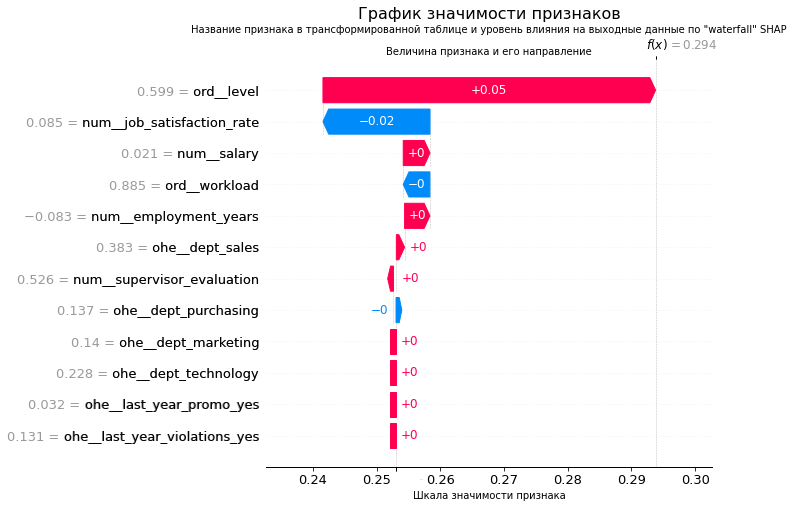

In [87]:
best_model = rs.best_estimator_

X_transformed = pd.DataFrame(data_preprocessor.transform(X_test_2), columns=data_preprocessor.get_feature_names_out())

explainer = shap.TreeExplainer(best_model.named_steps['models'])

shap_values = explainer(X_transformed)

shap_values_sum = 0
for i in range(1, len(shap_values)):
    shap_values_sum += shap_values[i]
    
shap.plots.waterfall(((shap_values_sum / len(shap_values))[:,1]), max_display=20, show=False)
fig, ax = plt.gcf(), plt.gca()

ax.set_title('График значимости признаков', fontsize=16)
ax.set_xlabel('Название признака в трансформированной таблице и уровень влияния на выходные данные по "waterfall" SHAP')
ax.set_ylabel('Урые данные модели)', fontsize=14)

cb_ax0 = fig.axes[0] 
cb_ax0.set_xlabel('Шкала значимости признака')

cb_ax1 = fig.axes[1] 
cb_ax1.tick_params( labelsize=0)
cb_ax1.set_xlabel('Величина признака и его направление')

plt.show()


Проверим лучшую модель на соответствие условию: ROC-AUC ≥ 0.91 на тестовой выборке.

In [88]:
roc_auc_rs_test = roc_auc_score(y_test_2, rs.predict_proba(X_test_2)[:, 1])
if (roc_auc_rs_test >= 0.91):
    print ('Модель удовлетворяет условию: на тестовой выборке ROC-AUC', round(roc_auc_rs_test, 4), '>= 0.91')
else:
    print('Модель не удовлетворяет условию:  ROC-AUC на тестовой выборке >= 0.91 n\ ТРЕБУЕТСЯ ДОПОЛНИТЕЛЬНОЕ ИССЛЕДОВАНИЕ')

Модель удовлетворяет условию: на тестовой выборке ROC-AUC 0.9234 >= 0.91


Отобранная модель соответствует условию.

In [89]:
dummy_class = DummyClassifier(strategy='stratified', random_state=RANDOM_STATE)
dummy_class.fit(X_train_2, y_train_2)

roc_auc_rs_train = roc_auc_score(y_train_2, rs.predict_proba(X_train_2)[:, 1])
print(f'Значение ROC-AUC лучшей модели на обучающей выборке: {round(roc_auc_rs_train, 4)}')
roc_auc_rs_train = roc_auc_score(y_train_2, dummy_class.predict_proba(X_train_2)[:, 1])
print(f'Значение ROC-AUC модели `DummyClassifier` на обучающей выборке: {round(roc_auc_rs_train, 4)}')
print('-------------------------------')
roc_auc_rs_test = roc_auc_score(y_test_2, rs.predict_proba(X_test_2)[:, 1])
print(f'Значение ROC-AUC лучшей модели на тестовой выборке: {round(roc_auc_rs_test, 4)}')
roc_auc_rs_test = roc_auc_score(y_test_2, dummy_class.predict_proba(X_test_2)[:, 1])
print(f'Значение ROC-AUC модели `DummyClassifier` на тестовой выборке: {round(roc_auc_rs_test, 4)}')

Значение ROC-AUC лучшей модели на обучающей выборке: 0.9338
Значение ROC-AUC модели `DummyClassifier` на обучающей выборке: 0.5017
-------------------------------
Значение ROC-AUC лучшей модели на тестовой выборке: 0.9234
Значение ROC-AUC модели `DummyClassifier` на тестовой выборке: 0.5013


## 7. Выводы

В процессе отбора определили модель, которая удовлетворяет требованию: ROC-AUC на тестовой выборке ≥ 0.91 , при этом указанный показатель у модели `DecisionTreeClassifier(criterion='log_loss', max_depth=6, max_leaf_nodes=30, min_samples_leaf=3, min_samples_split=7, random_state=42)` = 0.9234.

Её параметры `{'preprocessor__num': RobustScaler(), 'models__splitter': 'best', 'models__min_samples_split': 7, 'models__min_samples_leaf': 3, 'models__max_leaf_nodes': 30, 'models__max_depth': 6, 'models__criterion': 'log_loss'}`

Данная модель лучше справилась с прогнозированием, так как при её построении было перебрано больше параметров и на неё меньше оказывают влияния существующие выбросы в данных.

Для указанной определены значимые признаки (по убыванию):
1. level - `+` - уровень занимаемой должности
2. job_satisfaction_rate - `-` - уровень удовлетворенности сотрудника работой
3. salary - `+` - ежемесячная зарплата сотрудника
4. workload - `-` - уровень загруженности сотрудника
5. employment_years - `+` - длительность работы в компании

Модель оценена на адекватность, её качество по метрике ROC-AUC значительно превосходит метрику модели `DummyClassifier`
+ Значение ROC-AUC лучшей модели на обучающей выборке: 0.9338
+ Значение ROC-AUC модели `DummyClassifier` на обучающей выборке: 0.5017

# Общий вывод

В работе требовалось оптимизировать управление персоналом и предложить бизнесу, как избежать финансовых потерь из-за оттока сотрудников.

Задача решалась в 2 этапа:

1. Построение модели, которая предсказывает уровень удовлетворённости работой в компании
    1. Загрузка данных
        + Данные соответствуют описанным
    2. Предобработка данных
        + В колонках данные соответствуют типу
        + Дубликаты не обнаружены 
        + Выявлены пропуски в колонках `dept`и `level`, в колонках train_job_satisfaction_rate['dept'] и test_features['workload'] обнаружены пробелы, проведена замена пробелов `' '` на `np.nan`
        + исправлена ошибка `sinior` на `senior`
    3. Исследовательский анализ данных
        + данные `id`, переведены в индекс, отсортированы по возрастающей
        + в данных обнаружены выбросы
        + Между входными параметрами отсутствует связь выше 0,9 следовательно при обучении модели учитывать мультиколлинеарность не надо 
        + В колонках `dept`, `level`, `workload` необходимо заменить пропуски
        + Три признака: `dept`, `last_year_promo`, `last_year_violations` — нужно кодировать с помощью OneHotEncoder
        + Два признака: `level`, `workload` — нужно кодировать с помощью OrdinalEncoder
        + Три признака: `employment_years`, `supervisor_evaluation`, `salary` - достаточно масштабировать
    4. Подготовка данных
        + Заполнены пропуски
        + Проведено кодирование в соответствии с признаками (использовано два кодировщика `ohe - OneHotEncoder`, `ord - OrdinalEncoder`)
        + Проведено масштабирование данных
    5. Обучение моделей
        + В процессе работы отобрана лучшая модель: `DecisionTreeRegressor(max_features=9, random_state=42)` с параметрами: `{'preprocessor__num': MinMaxScaler(), 'models__max_features': 9, 'models__max_depth': None, 'models': DecisionTreeRegressor(max_features=9, random_state=42)}`
        + Качество модели удовлетворяет критерию успеха SMAPE ≤ 15 на тестовой выборке: 14.3863
    6. Оформление выводов
        + В процессе обучения моделей и подбора параметров работа производилась для: LinearRegression() и  DecisionTreeRegressor()
        + В процессе работы отобрана лучшая модель: `DecisionTreeRegressor(max_depth=14, max_features=9, random_state=42)` с параметрами: `{'preprocessor__num': 'passthrough', 'models__max_features': 9, 'models__max_depth': 14, 'models': DecisionTreeRegressor(max_depth=14, max_features=9, random_state=42)}`
        + В процессе работы отбор модели производился по целевой функции SMAPE. Качество лучшей модели удовлетворяет: Критерию успеха SMAPE ≤ 15 на тестовой выборке: 14.7877
        + Объяснено: Почему LinearRegression() хуже справилась с поставленной задачей. Потому что матрица корреляции, явно показала отсутствие явной линейной зависимости между входными и целевыми показателями максимальное значение phi(k) = 0,79 и потому что DecisionTreeRegressor() оперативно подстроилось между входными и целевыми параметрами во время обучения и меньше подвержена влиянию выбросов во входных данных
        + Отобранная лучшая модель прошла проверку на адекватность
    
2. Построение модели, которая предсказывает увольнение сотрудника из компании
    1. Загрузка данных
        + Данные соответствуют описанным
    2. Предобработка данных
        + В колонках данные соответствуют типу
        + Дубликаты не обнаружены
        + Выявлены пропуски в колонках `dept`и `level`, в колонках `test_features['dept']` и `test_features['workload']` обнаружены пробелы, проведена замена пробелов `' '` на `np.nan`
        + исправлена ошибка `sinior` на `senior`    
    3. Исследовательский анализ данных
        + Принято решение провести повторное исследование данных так как в таблицах `train_job_satisfaction_rate` и `train_quit` значения в столбцах `id` не совпадают, а значит данные могут быть разными
        + Составили портрет уволившегося сотрудника: 
            + Начинающий сотрудник (отработал всего год) с вероятностью 53% 
            + Навыки работы - junior с вероятностью 89%
            + Оценен руководителем на 3 по 5-ти бальной шкале с вероятностью 46%
            + Является сотрудником отдела Sales с вероятностью 36%, отдела Technology - 24%
            + Загрузка сотрудника Low с вероятностью 46% и Medium - 43%
            + В течении года нарушал трудовую дисциплину с вероятностью 20%
            + Медианная заработная плата составляет 22800, в то время как продолживших работать 34800
        + Провели сопоставление признаков удовлетворенности работой и увольнением сотрудников. 
            + Построенные гистограммы с боксплотами и плотность распределения удовлетворенности работой, указывает на связь с увольнением сотрудников.
    4. Добавление нового входного признака
        + Добавили признак `job_satisfaction_rate`, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи
        + Проверили отсутствие наличия мультиколлениарности в данных
    5. Подготовка данных
        + При подготовке данных использовано два кодировщика, осуществлен визуальный контроль подготовки данных в пайплайне.
    6. Обучение модели
        + Проведенна настройка и поиск параметров модели в ручном и автоматическом режиме при помощи пайплайнов
        + Определены значимые признаки для лучшей модели `DecisionTreeClassifier` (по убыванию):
            1. level - `+` - уровень занимаемой должности
            2. job_satisfaction_rate - `-` - уровень удовлетворенности сотрудника работой
            3. salary - `+` - ежемесячная зарплата сотрудника
            4. workload - `-` - уровень загруженности сотрудника
            5. employment_years - `+` - длительность работы в компании
    + Оформлен вывод по разделу
        + В процессе отбора определили модель, которая удовлетворяет требованию: ROC-AUC на тестовой выборке ≥ 0.91 , при этом указанный показатель у модели `DecisionTreeClassifier(criterion='log_loss', max_depth=6, max_leaf_nodes=30, min_samples_leaf=3, min_samples_split=7, random_state=42)` = 0.9234. Её параметры `{'preprocessor__num': RobustScaler(), 'models__splitter': 'best', 'models__min_samples_split': 7, 'models__min_samples_leaf': 3, 'models__max_leaf_nodes': 30, 'models__max_depth': 6, 'models__criterion': 'log_loss'}`
        + Данная модель лучше справилась с прогнозированием, так как при её построении было перебрано больше параметров и на неё меньше оказывают влияния существующие выбросы в данных
        + Для указанной модели определены значимые признаки (по убыванию):
            1. level - `+` - уровень занимаемой должности
            2. job_satisfaction_rate - `-` - уровень удовлетворенности сотрудника работой
            3. salary - `+` - ежемесячная зарплата сотрудника
            4. workload - `-` - уровень загруженности сотрудника
            5. employment_years - `+` - длительность работы в компании

        + Модель оценена на адекватность, её качество по метрике ROC-AUC превосходит метрику модели `DummyClassifier`
            + Значение ROC-AUC лучшей модели на обучающей выборке: 0.9338
            + Значение ROC-AUC модели `DummyClassifier` на обучающей выборке: 0.5017
   
3. Общий вывод
    + Составлен данный вывод





#### Предложения для бизнеса:

В целях уменьшения увольнения персонала и сокращения издержек, предлагается:

Основное направление состредоточить на наиболее значимых признаках, в большей степени влияющих на увольненние сотрудников (по убывающей):

+ `level` - уровень занимаемой должности -  как правило увольняются новички. В данном направлении необходимо указывать работникам перспективы карьерного роста - заинтересовывать новыми направлениями.
+ `job_satisfaction_rate` - уровень удовлетворенности сотрудника работой - в процессе работы определено, что есть зависимость между удовлетворенностью работой и увольнением - возможно провести дополнительное тестирование работников и выяснить, что именно им не нравится в работе.
+ `salary` - ежемесячная зарплата сотрудника - из анализа видно, что увольняются работники медианная зарплата которых ниже работников оставшихся работать.
+ `workload` - уровень загруженности сотрудника, влияет на увольнение, но в большей степени увольняются работники с низкой загруженностью. Возможно, увеличить нагрузку на сотрудника и одновременно с этим увеличить заработную плату, будет хорошим решением.
+ `employment_years` - длительность работы в компании - чем больше сотрудник работает в компании, тем меньше вероятность его увольнения. Следует заинтересовавать и стимулировать молодых специалистов имеющих стаж работы на предприятии менее двух лет.

Основное усилие работы сосредоточить на категории работников наиболее склонных к увольнению:
+ Начинающий сотрудник (отработал всего год) с вероятностью 53% 
+ Навыки работы - junior с вероятностью 89%
+ Оценен руководителем на 3 по 5-ти бальной шкале с вероятностью 46%
+ Является сотрудником отдела Sales с вероятностью 36%, отдела Technology - 24%
+ Загрузка сотрудника Low с вероятностью 46% и Medium - 43%
+ В течении года нарушал трудовую дисциплину с вероятностью 20%
+ Медианная заработная плата составляет 22800, в то время как продолживших работать 34800